In [1]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
import htmd.ui as ht
import htmd.molecule.voxeldescriptors as vd
import csv
import pickle
import numpy as np
from tqdm import *
import bcolz as bc
import glob
import os
import random
from sklearn.metrics import r2_score

Using TensorFlow backend.



HTMD License accepted automatically. Check license here: https://raw.githubusercontent.com/Acellera/htmd/master/htmd/LICENCE.txt

For advanced features (e.g. parameterize) and to remove this message, we recommend registering. Run htmd_register in your terminal.

Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. 
https://dx.doi.org/10.1021/acs.jctc.6b00049
Documentation: http://software.acellera.com/
To update: conda update htmd -c acellera -c psi4

You are on the latest HTMD version (1.12.3).



In [2]:
np.random.seed = 3353

In [3]:
def split_data(length, valid_size=0.1, test_size=0.1):
    """
    INPUT: length of the data
    OUTPUT: Indices of the data.
    """
    # Generate indices
    indices = [i for i in range(length)]
    # Get required number of test and validation indices
    test_count = int(length*test_size)
    valid_count = int(length*valid_size)
    # Choose random test indices
    test_ids = list(np.random.choice(indices, test_count))
    # Remove test ids from indices
    indices = list(set(indices) - set(test_ids))
    # Choose random validation indices
    valid_ids = list(np.random.choice(indices, valid_count))
    # Remove valid ids from indices
    train_ids = list(set(indices) - set(valid_ids))
    
    return train_ids, valid_ids, test_ids

In [4]:
# Read the data file and get all the pdb ids
def read_score():
    pdb_ids = []
    score = {}
    with open('pdbbind_refined_set.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None) # Skip the header
        for row in reader:
            pdb_ids.append(row[1])
            score[row[1]]= float(row[5])

    return pdb_ids, score

In [5]:
ids, scores = read_score()

### Feature extraction

In [7]:
features = {}
filepath = "features_dict.pickle"
if os.path.isfile(filepath):
    print("Loading features...", end='')
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    print("Done")
else:
    print("Extracting features", end='')
    # Get the pocket files
    data_dir = "../../pdbbind_data/"
    files = glob.glob(data_dir + "*/*/*_pocket.pdb", recursive=True)
    
    pbar = tqdm_notebook(total=len(files))
    for i, file in enumerate(files):
        m = ht.Molecule(file)
        _id = m.viewname[:4]
        try:
            f, centers, natoms = vd.getVoxelDescriptors(m)
            f = f.reshape(natoms[0], natoms[1], natoms[2], -1)
            features[_id] = f
        except:
            continue
        pbar.update()
    with open("features_dict.pickle", "wb") as f:
        pickle.dump(features, f)
    print("Done")

print("Feature dictionary length: ", len(features))

Loading features...Done
Feature dictionary length:  3971


Let's look at the shapes

In [8]:
shapes = []
for i, k in enumerate(features.keys()):
    shapes.append(features[k].shape)

In [9]:
max_shape = np.max(shapes, axis=0)
max_shape

array([47, 45, 46,  8])

In [10]:
min_shape = np.min(shapes, axis=0)
min_shape

array([17, 17, 17,  8])

Reshape to 50 voxel size (padding with zeros)

In [11]:
bc_path = 'bc_features'
pdb_ids_file = 'pdb_ids_list'
pdb_ids = []

# Load the pdb_ids if available
if os.path.isfile(pdb_ids_file):
    with open(pdb_ids_file, 'rb') as f:
        pdb_ids = pickle.load(f)

# Load the reshaped features if available
if os.path.isdir(bc_path):
    print("Loading reshaped features '", bc_path, "' from the disk")
    re_features = bc.open(bc_path)
    
else:
    print("Reshaping data and saving to the disk as '", bc_path, "'")
    voxel_size = 50
    n_channels = 8
    re_features = np.zeros([len(features), voxel_size, voxel_size, voxel_size, n_channels])
    pbar = tqdm_notebook(total=len(features))
    for i, (k, f) in enumerate(features.items()):
        pdb_ids.append(k)
        dim_diff = (re_features.shape[1:] - np.array(f.shape)).astype(int)
        pad_dim = np.round(dim_diff / 2).astype(int)
        f = np.pad(f, [(pad_dim[0], dim_diff[0]-pad_dim[0]),
                       (pad_dim[1], dim_diff[1]-pad_dim[1]),
                       (pad_dim[2], dim_diff[2]-pad_dim[2]),
                       (0, 0)],
                   'constant')
        re_features[i] = f
        pbar.update()
    
    # Create a bc array   
    bc_features = bc.carray(re_features, rootdir=bc_path)
    # Write to the disk
    bc_features.flush()
    # Write the pdb ids
    with open(pdb_ids_file, 'wb') as f:
        pickle.dump(pdb_ids, f)
        
print("Reshaped feature shape: ", re_features.shape, " and number of pdb ids: ", len(pdb_ids))

Loading reshaped features ' bc_features ' from the disk
Reshaped feature shape:  (3971, 50, 50, 50, 8)  and number of pdb ids:  3971


### Preprocess

Filter and create data

In [6]:
x_path = "bc_x_data"
y_path = "y_data.pickle"

if os.path.isfile(y_path):
    with open(y_path, 'rb') as f:
        y_data = pickle.load(f)

if os.path.isdir(x_path):
    x_data = bc.open(x_path)
else:
    x_data = np.zeros(re_features.shape)
    y_data = np.zeros(re_features.shape[0])

    count = 0
    pbar = tqdm_notebook(total=re_features.shape[0])
    for i, _id in enumerate(pdb_ids):
        if _id in scores.keys():
            x_data[count] =  re_features[i]
            y_data[count] = scores[_id]
            count = count + 1
        pbar.update()

    x_data = x_data[:count]
    y_data = y_data[:count]
    
    # Write to the disk
    bc_x_data = bc.carray(x_data, rootdir = x_path)
    bc_x_data.flush()
    with open(y_path, 'wb') as f:
        pickle.dump(y_data, f)

print("Shape of x data: ", x_data.shape, " and shape of y_data: ", y_data.shape)

Shape of x data:  (3735, 50, 50, 50, 8)  and shape of y_data:  (3735,)


Normalize

In [7]:
mean = np.mean(x_data, axis=0)
std = np.std(x_data, axis=0)
x_data = (x_data - mean)/(std + 0.000001)

print("Shape of the normalized x data: ", x_data.shape)

Shape of the normalized x data:  (3735, 50, 50, 50, 8)


Split

In [8]:
train_ids, valid_ids, test_ids = split_data(length=x_data.shape[0])

Check if there is any common ids

In [9]:
list(set(train_ids).intersection(set(valid_ids)).intersection(test_ids))

[]

In [10]:
def generator(batch_size, mode='train'):
    global x_data
    global y_data
    global train_ids
    global valid_ids
    
    while True:
        if mode == 'train':
            rand_ids = np.random.choice(train_ids, batch_size)
            sample_x, sample_y = x_data[rand_ids], y_data[rand_ids]
        else:
            rand_ids = np.random.choice(valid_ids, batch_size)
            sample_x, sample_y = x_data[rand_ids], y_data[rand_ids]
        
        yield sample_x, sample_y

In [11]:
# Let's warm up the generator
%time bx, by = next(generator(10), 'valid')
bx.shape, by.shape

CPU times: user 14.5 ms, sys: 19.2 ms, total: 33.7 ms
Wall time: 32.8 ms


((10, 50, 50, 50, 8), (10,))

In [22]:
class CustomSequence(Sequence):
    def __init__(self, batch_size):
        global x_data_n
        global y_data
        self.X,self.y = x_data_n, y_data
        self.batch_size = batch_size
        self.counter = 0
        self.epoch_counter = 0

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self,idx):
#         print("Batch #: ", str(idx))
#         print("From ", str(idx*self.batch_size), " to ", str((idx+1)*self.batch_size))
        batch_x = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
#         print("Returned batch size: ", str(len(batch_x)))
        self.counter += 1
        
        return np.array(batch_x), np.array(batch_y)
        
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
#         print('\nEpoch end: ' + str(self.epoch_counter) + ' counter: ' + str(self.counter))
        self.epoch_counter +=1

### Train

In [12]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(5, 5, 5),
                     strides = (2, 2, 2),
                     input_shape=(50, 50, 50, 8),
                     padding='valid',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     activation='relu',
                     padding='valid'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [13]:
get_model(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 23, 23, 23, 32)    32032     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 11, 11, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 9, 9, 64)       55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 2, 2, 128)      221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [14]:
nb_gpus = 8
nb_batch = nb_gpus*16
nb_epochs = 50

model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.adam(lr=0.0001),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [23]:
# checkpoint
print(model.metrics_names)
filepath="weights-improvement-{epoch:02d}-{val_mean_squared_error:.2f}.hdf5"
# For multi_gpu_model, save_weights_only should be set to True. Otherwise, saving of the multi_gpu_model will cause an error
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
callbacks_list = [checkpoint]

['loss', 'mean_squared_error']


In [24]:
# train_gen = CustomSequence(batch_size=nb_batch)

In [25]:
valid_x, valid_y = x_data[valid_ids], y_data[valid_ids]

In [26]:
history = model.fit_generator(generator(batch_size=nb_batch), validation_data=(valid_x, valid_y),
                              epochs=nb_epochs,
                              steps_per_epoch=len(train_ids)//nb_batch, 
                              callbacks=callbacks_list, 
                              verbose=1)

Epoch 1/50
23/23 [==============================] - 18s 795ms/step - loss: 5.6610 - mean_squared_error: 5.6610 - val_loss: 4.1306 - val_mean_squared_error: 4.1306

Epoch 00001: val_mean_squared_error improved from inf to 4.13061, saving model to weights-improvement-01-4.13.hdf5
Epoch 2/50
23/23 [==============================] - 18s 790ms/step - loss: 4.4285 - mean_squared_error: 4.4285 - val_loss: 3.7226 - val_mean_squared_error: 3.7226

Epoch 00002: val_mean_squared_error improved from 4.13061 to 3.72256, saving model to weights-improvement-02-3.72.hdf5
Epoch 3/50
23/23 [==============================] - 19s 808ms/step - loss: 4.2278 - mean_squared_error: 4.2278 - val_loss: 3.7273 - val_mean_squared_error: 3.7273

Epoch 00003: val_mean_squared_error did not improve
Epoch 4/50
23/23 [==============================] - 18s 762ms/step - loss: 3.8627 - mean_squared_error: 3.8627 - val_loss: 3.5536 - val_mean_squared_error: 3.5536

Epoch 00004: val_mean_squared_error improved from 3.72256 


Epoch 00033: val_mean_squared_error did not improve
Epoch 34/50
23/23 [==============================] - 18s 771ms/step - loss: 1.9906 - mean_squared_error: 1.9906 - val_loss: 2.9579 - val_mean_squared_error: 2.9579

Epoch 00034: val_mean_squared_error did not improve
Epoch 35/50
23/23 [==============================] - 18s 782ms/step - loss: 1.8132 - mean_squared_error: 1.8132 - val_loss: 2.9372 - val_mean_squared_error: 2.9372

Epoch 00035: val_mean_squared_error improved from 2.94599 to 2.93721, saving model to weights-improvement-35-2.94.hdf5
Epoch 36/50
23/23 [==============================] - 18s 782ms/step - loss: 1.8799 - mean_squared_error: 1.8799 - val_loss: 3.4608 - val_mean_squared_error: 3.4608

Epoch 00036: val_mean_squared_error did not improve
Epoch 37/50
23/23 [==============================] - 18s 785ms/step - loss: 1.7720 - mean_squared_error: 1.7720 - val_loss: 2.9756 - val_mean_squared_error: 2.9756

Epoch 00037: val_mean_squared_error did not improve
Epoch 38/50


In [32]:
# Get the model and load the last saved weights

model = get_model()
model = multi_gpu_model(model, gpus=nb_gpus)
model.load_weights("model-weights-35-2.94.hdf5")

Test performance

In [33]:
test_x, test_y = x_data[test_ids], y_data[test_ids]

In [34]:
pred = model.predict(test_x)

In [35]:
r2 = r2_score(y_pred=pred, y_true=test_y)
r2

0.4087525212512636

Plot history

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

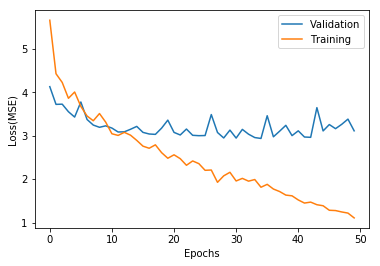

In [39]:
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.legend(["Validation", "Training"])
plt.show()